In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import subprocess
import io
import copy
import matplotlib.pyplot as plt
import glob
import numpy as np
import toml
import seaborn as sns
from tqdm.auto import tqdm
from sleap import Labels, Video, Skeleton


In [19]:
import json

In [20]:
# load in template

# Parse grid search

1. TODO: need to check mAP test/train to see how robust learning is
2. TODO: match 1 with overall performance (maybe equal weighting after normalize?)

In [21]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"
os.makedirs(save_dir, exist_ok=True)

In [22]:
import sleap
import pandas as pd
import re
from qd_analysis.fig import setup_plotting_env

In [153]:
# gridsearch_dir = ["/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_03",
#                   "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_fused_v2_04"
#                  ]
gridsearch_dir = ["/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/sleap_training/gridsearch_qds_kneejoints_fused_05/"]
training_configs_fnames = []
for _dir in gridsearch_dir:
    training_configs_fnames += glob.glob(os.path.join(_dir, "**/initial_config.json"), recursive=True)

In [154]:
training_configs_fnames = sorted(training_configs_fnames)

In [155]:
all_metrics = []
for _config_fname in tqdm(training_configs_fnames):
    # dir
    param_dct = {}
    use_dir = os.path.dirname(_config_fname)
    param_dir = os.path.basename(use_dir)

    val_metric_fname = os.path.join(use_dir, "metrics.val.npz")
    train_metric_fname = os.path.join(use_dir, "metrics.train.npz")
    
    try:
        val_metric = sleap.load_metrics(val_metric_fname)
        train_metric = sleap.load_metrics(train_metric_fname)
    except FileNotFoundError:
        try:
            # need to recompute for single node skeletons...
            labels_gt = sleap.load_file(os.path.join(use_dir, "labels_gt.val.slp"))
            labels_pr = sleap.load_file(os.path.join(use_dir, "labels_pr.val.slp"))

            # manually give the scale here..
            val_metric = sleap.nn.evals.evaluate(
                    labels_gt, labels_pr, oks_scale=10, user_labels_only=True 
            )
            labels_gt = sleap.load_file(os.path.join(use_dir, "labels_gt.train.slp"))
            labels_pr = sleap.load_file(os.path.join(use_dir, "labels_pr.train.slp"))
            train_metric = sleap.nn.evals.evaluate(
                    labels_gt, labels_pr, oks_scale=10, user_labels_only=True
            )
        except (FileNotFoundError, IndexError):
            continue

    with open(_config_fname, "r") as f:
        initial_config = json.load(f)

    with open(os.path.join(use_dir, "training_config.json"), "r") as f:
        training_config = json.load(f)

    total_nframes = len(training_config["data"]["labels"]["training_inds"] + training_config["data"]["labels"]["validation_inds"])
    training_nframes = len(training_config["data"]["labels"]["training_inds"])
    
    slp_data = sleap.load_file(os.path.join(use_dir, "labels_gt.train.slp"))
    node_names = [_.name for _ in slp_data.skeletons[0].nodes]
    node_dists = np.nanmean(val_metric["dist.dists"], axis=0)
    param_dct["val_mDist"] = np.nanmean(val_metric["dist.avg"])
    param_dct["val_mDist2"] = np.nanmean(node_dists)
    param_dct["val_dist.p50"] = np.nanmean(val_metric["dist.p50"])
    param_dct["val_dist.p90"] = np.nanmean(val_metric["dist.p90"])
    param_dct["val_map"] = val_metric["oks_voc.mAP"]
    param_dct["train_mDist"] = np.nanmean(train_metric["dist.avg"])
    param_dct["train_map"] = train_metric["oks_voc.mAP"]
    param_dct["basename"] = os.path.basename(os.path.dirname(_config_fname))
    param_dct["condition"] = "all"
    
    # df.loc[df["basename"].str.contains("holdoutcam"),"condition"] = "out_distribution_cam"
    
    all_metrics.append(param_dct)

  0%|          | 0/27 [00:00<?, ?it/s]

/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:539: RuntimeWarning: Mean of empty slice
  "dist.avg": np.nanmean(dists),
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:572: RuntimeWarning: Mean of empty slice.
  mPCK = mPCK_parts.mean()
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:666: RuntimeWarning: Mean of empty slice.
  pair_pck = metrics["pck.pcks"].mean(axis=-1).mean(axis=-1)
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/jmarkow/miniconda3/envs/sleap-analysis/lib/python3.10/site-packages/sleap/nn/evals.py:668: Runti

In [156]:
df = pd.DataFrame(all_metrics)

In [157]:
df["weights"] = df.sort_values("val_mDist")["basename"].str.extract("weights-(.*)_bpass")

In [158]:
df

,val_mDist,val_mDist2,val_dist.p50,val_dist.p90,val_map,train_mDist,train_map,basename,condition,weights
0,2.724962,2.724962,2.532993,4.563509,0.000000,2.563681,0.000027,unet_filters_rate-1.5_training_labels-train_fr...,all,"(0.0, 1.0)"
1,2.924990,2.910645,2.759942,5.055368,0.000000,2.180819,0.000022,unet_filters_rate-1.5_training_labels-train_fr...,all,"(0.0, 1.0)"
2,1.397514,1.387089,1.227805,2.400232,0.000000,1.547223,0.000660,unet_filters_rate-1.5_training_labels-train_fr...,all,"(1.0, 0.0)"
3,1.621132,1.620481,1.606493,2.325318,0.000000,1.473200,0.001149,unet_filters_rate-1.5_training_labels-train_fr...,all,"(1.0, 0.0)"
4,1.374699,1.375672,1.379262,2.121129,0.000226,1.472428,0.000096,unet_filters_rate-1.5_training_labels-train_fr...,all,"(1.0, 0.0)"
5,1.428215,1.432848,1.139854,2.594640,0.000000,1.512448,0.000272,unet_filters_rate-1.5_training_labels-train_fr...,all,None
6,1.638104,1.638488,1.557494,2.594459,0.000000,1.444251,0.000268,unet_filters_rate-1.5_training_labels-train_fr...,all,None
7,1.406810,1.408870,1.377433,2.088160,0.000405,1.471206,0.000063,unet_filters_rate-1.5_training_labels-train_fr...,all,None
8,2.405926,2.409743,2.312428,4.312474,0.000000,2.192536,0.000072,unet_filters_rate-1.75_training_labels-train_f...,all,"(0.0, 1.0)"
9,2.765947,2.784119,2.626491,4.684395,0.000000,2.142828,0.000045,unet_filters_rate-1.75_training_labels-train_f...,all,"(0.0, 1.0)"


In [159]:
df["val_mDist"]

0     2.724962
1     2.924990
2     1.397514
3     1.621132
4     1.374699
5     1.428215
6     1.638104
7     1.406810
8     2.405926
9     2.765947
10    2.498900
11    1.447224
12    1.604869
13    1.423760
14    1.506995
15    1.544940
16    1.454334
17    3.070087
18    2.718532
19    1.434394
20    1.645936
21    1.465782
22    1.463699
23    1.503115
24    1.429755
Name: val_mDist, dtype: float64

In [160]:
df["val_mDist"]

0     2.724962
1     2.924990
2     1.397514
3     1.621132
4     1.374699
5     1.428215
6     1.638104
7     1.406810
8     2.405926
9     2.765947
10    2.498900
11    1.447224
12    1.604869
13    1.423760
14    1.506995
15    1.544940
16    1.454334
17    3.070087
18    2.718532
19    1.434394
20    1.645936
21    1.465782
22    1.463699
23    1.503115
24    1.429755
Name: val_mDist, dtype: float64

In [161]:
df.groupby("weights")["val_mDist"].std()

weights
(0.0, 1.0)    0.228605
(1.0, 0.0)    0.103951
None          0.072125
Name: val_mDist, dtype: float64

In [162]:
df["weights"].iat[0]

'(0.0, 1.0)'

In [163]:
setup_plotting_env()

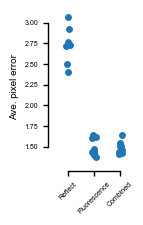

In [164]:
fig, ax = plt.subplots(1, figsize=(1., 2.))
sns.stripplot(data=df,
            order=["(0.0, 1.0)","(1.0, 0.0)",None],
            x="weights",
            y="val_mDist")
ax.set_xlabel("")
ax.set_ylabel("Ave. pixel error")
ax.set_xticks([0,1,2], ["Reflect","Fluorescence","Combined"], rotation=45)
ax.tick_params(axis='x', rotation=45)
sns.despine(offset=5, trim=True)
# fig.savefig(os.path.join(save_dir, "kpoint_fused_labeling_model_perf.pdf"), dpi=600, bbox_inches="tight")

In [175]:
df.query("weights == 'None'").sort_values("val_mDist").iloc[0]["basename"]

'unet_filters_rate-1.5_training_labels-train_frames_kneejoints_fused_weights-None_bpass-None.slp_repeat-2.single_instance'